Large public-domain corpora such as Project Gutenberg remain a foundational resource for computational linguistics and digital humanities. However, the textual artefacts surrounding the literary work itself—licence notices, metadata, editorial commentary, and boilerplate—must be removed before meaningful analysis can begin. In their tutorial for the NLTk third-party python package, Bird, Klein, and Loper state that “we cannot reliably detect where the content begins and ends, and so have to resort to manual inspection of the file, to discover unique strings that mark the beginning and the end, before trimming raw to be just the content and nothing else” [1]. This observation was reasonable in the context of rule-based preprocessing pipelines and early NLP tooling.

This notebook revisits that assumption in light of dramatic improvements in the proficiency of large language models (LLMs). It demonstrates how an LLM, accessed via the OpenAI API, can be used to automate the identification of content boundaries in Project Gutenberg texts with a high degree of reliability. Rather than relying on brittle heuristics or manual inspection, the approach treats boundary detection as a semantic and genre-classification problem: given a raw text stream, the model infers where the literary content begins and ends based on patterns learned across many similar documents.

The purpose of this document is not to present a novel model architecture, but to show how existing general-purpose LLMs can be integrated into practical text-processing workflows to remove a long-standing source of friction in corpus preparation. The guiding design principle is: prompt the LLM for semantic judgment, then use Python for exact slicing.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv
import openai

def setup_openai():
    env_file = find_dotenv("OPENAI API KEY.env")

    if not env_file:
        raise FileNotFoundError("Could not find 'OPENAI API KEY.env' in the current or parent directories.")

    load_dotenv(env_file)
    api_key = os.getenv("OPENAI_API_KEY")

    if not api_key:
        raise ValueError("OPENAI_API_KEY not found in environment file")

    return openai.OpenAI(api_key=api_key)

client = setup_openai()
print("OpenAI client successfully initialized!")

OpenAI client successfully initialized!


At this stage, we acquire the raw text to be processed from Project Gutenberg's catalog [https://www.gutenberg.org/]. Project Gutenberg provides multiple formats for each work; here we explicitly select the plain ASCII .txt version (highlighted below) to minimise downstream preprocessing complexity. The URL is obtained manually from the Project Gutenberg catalogue and passed directly to the notebook, making the data source transparent and reproducible.

The code below performs a simple HTTP request, reads the full response into memory, and decodes it as UTF-8. The use of the 'utf-8-sig' codec ensures that any byte order mark (BOM), which is occasionally present in Gutenberg files, is safely removed before further processing. At this point, the resulting string still contains all non-literary material (licence text, metadata, and editorial boilerplate), which will be addressed in subsequent steps.

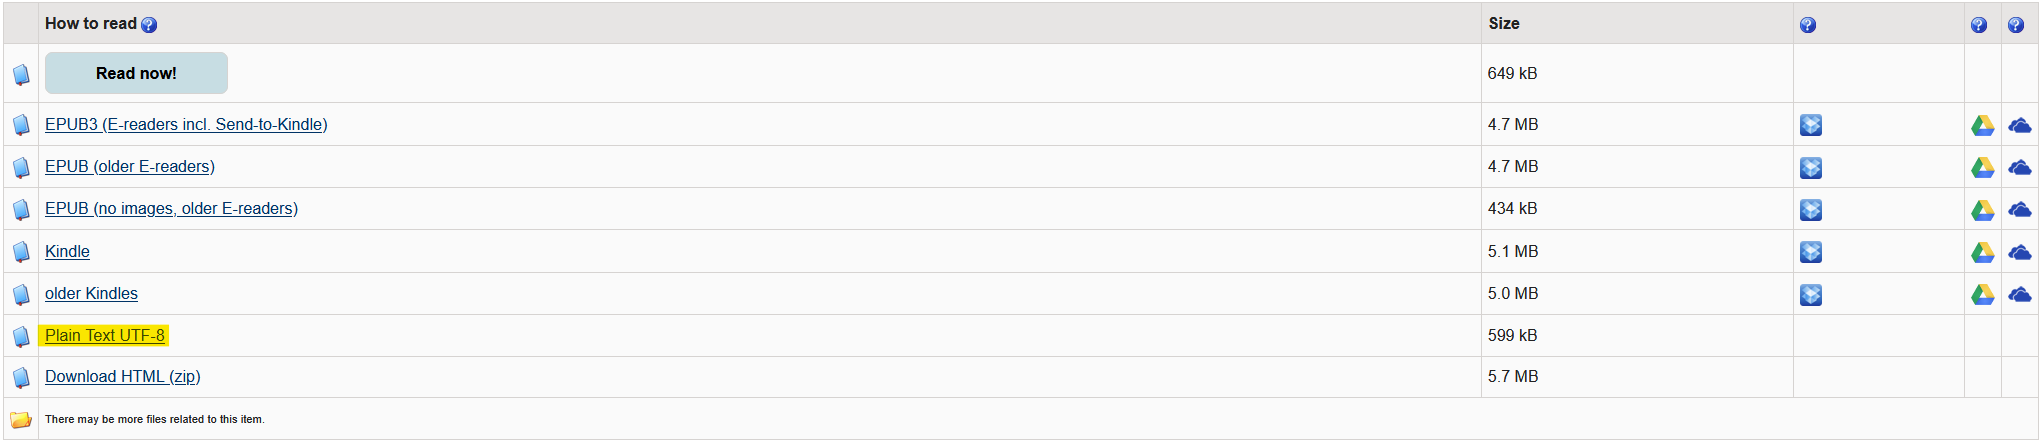

In [2]:
from urllib import request

# NOTE: manually insert direct link to the plain text version of a Project Gutenberg work
url = "https://www.gutenberg.org/cache/epub/42324/pg42324.txt"

# Open the specified URL and return a response object
url_response = request.urlopen(url)

# Decode as UTF-8 and strip any byte order mark that may be present
raw = url_response.read().decode('utf-8-sig')

import json
import re
import os
import unicodedata
from urllib import request as _request

# Use existing variables from the notebook: url, url_response, raw, cleaned_text, text_core,
# gutenberg_number, text_begin, text_end, text_end_anchor, target_end_node
# Fallbacks if any are not present
_text_raw = globals().get("raw")
if _text_raw is None and "url" in globals():
    try:
        _text_raw = _request.urlopen(url).read().decode("utf-8-sig")
    except Exception:
        _text_raw = ""

_cleaned = globals().get("cleaned_text", _text_raw)
_core = globals().get("text_core", "")
_gutenberg_id = globals().get("gutenberg_number")
_output_dir = globals().get("output_dir", "core_txts")

# Normalize
_text_raw_norm = unicodedata.normalize("NFC", _text_raw).replace("\r\n", "\n")
_cleaned_norm = unicodedata.normalize("NFC", _cleaned).replace("\r\n", "\n")
_core_norm = unicodedata.normalize("NFC", _core).replace("\r\n", "\n")

# Helper: extract header fields commonly present in Gutenberg files
def extract_header_field(text, name):
    m = re.search(rf"^{name}:\s*(.+)$", text, flags=re.I | re.M)
    return m.group(1).strip() if m else None

title_field = extract_header_field(_text_raw_norm, "Title")
author_field = extract_header_field(_text_raw_norm, "Author")
release_field = extract_header_field(_text_raw_norm, "Release Date")
language_field = extract_header_field(_text_raw_norm, "Language")
etext_match = re.search(r"Etext\s*#\s*[:#]?\s*(\d+)", _text_raw_norm, flags=re.I)
etext_number = etext_match.group(1) if etext_match else None

# Fallback title detection from core text (look for an all-caps centered title)
def detect_title_from_core(core):
    head = core[:3000]
    lines = [ln.strip() for ln in head.splitlines() if ln.strip()]
    for ln in lines[:40]:
        if len(ln) > 3 and ln.upper() == ln and re.search(r"[A-Z]", ln):
            # filter out short single-word headings like "PREFACE"
            if len(ln) >= 4:
                return ln
    return None

title_fallback = detect_title_from_core(_core_norm)
title = title_field or title_fallback or (title_fallback and title_fallback.title())

# Basic statistics
def word_count(s):
    return len(re.findall(r"\w+", s, flags=re.UNICODE))

metadata = {
    "gutenberg_id": _gutenberg_id or etext_number,
    "url": globals().get("url"),
    "http_headers": None,
    "raw_bytes": len(_text_raw.encode("utf-8")) if _text_raw else 0,
    "raw_characters": len(_text_raw_norm),
    "cleaned_characters": len(_cleaned_norm),
    "core_characters": len(_core_norm),
    "core_words": word_count(_core_norm),
    "title": title or title_field,
    "author": author_field,
    "release_date": release_field,
    "language": language_field,
    "etext_number": etext_number,
    "start_marker_index": globals().get("text_begin"),
    "end_marker_index": globals().get("text_end"),
    "start_anchor_index": globals().get("text_begin"),  # kept for compatibility
    "end_anchor_index": globals().get("text_end_anchor") or globals().get("text_end_idx"),
    "target_end_node": globals().get("target_end_node"),
}

# Try to capture HTTP response headers if available
_url_resp = globals().get("url_response")
try:
    if _url_resp is not None:
        # http.client.HTTPResponse: use getheaders() if present
        hdrs = None
        if hasattr(_url_resp, "getheaders"):
            hdrs = dict(_url_resp.getheaders())
        elif hasattr(_url_resp, "info"):
            info = _url_resp.info()
            hdrs = dict(info.items())
        metadata["http_headers"] = hdrs
except Exception:
    metadata["http_headers"] = None

# Attempt a short TOC/chapter-count heuristic: count "CHAPTER" occurrences in core
try:
    chap_matches = re.findall(r"\bCHAPTER\b", _core_norm, flags=re.I)
    metadata["chapters_heuristic_count"] = len(chap_matches)
except Exception:
    metadata["chapters_heuristic_count"] = None

# Ensure output directory exists and write JSON
os.makedirs(_output_dir, exist_ok=True)
out_fn = f"{metadata['gutenberg_id'] or 'unknown'}_metadata.json"
out_path = os.path.join(_output_dir, out_fn)

with open(out_path, "w", encoding="utf-8") as fh:
    json.dump(metadata, fh, ensure_ascii=False, indent=2)

print(out_path)The next step is to reduce the amount of text presented to the language model by isolating the opening and closing segments of the document. Prior to this isolation, the raw text is processed using the simple-cleaner utility from the gutenberg-cleaner library. This deterministic step programmatically removes standardized Project Gutenberg legal headers and footers. While the library offers a more aggressive "super-cleaner," it was rejected for this project due to its reliance on rigid heuristics that frequently misidentify short authorial lines, verse, or stylistic fragments as noise. By opting for a lighter preliminary clean, we preserve the structural nuance required for the model to perform its functional analysis of the text.

Following this initial cleanup, the remaining text is divided into fixed-length “head” and “tail” slices. For Project Gutenberg works, the information required to identify narrative boundaries is almost always located near these poles: the start-of-text marker, title page, and editorial preface appear in the opening section, while the end-of-text marker and license information appear in the closing section.

Extracting these slices substantially reduces token usage while preserving all relevant boundary cues. This design choice has practical implications beyond cost and latency. Recent empirical work has shown that large language models do not process long contexts uniformly: performance can degrade, sometimes unpredictably, as input length increases, even on simple and well-controlled tasks [2]. This phenomenon—referred to as context rot—suggests that providing the full raw text to the model is not merely inefficient, but may actively reduce reliability.

By constraining the model’s input to the most semantically informative regions of the document, we both minimize exposure to long-context degradation and improve interpretability. Separating the head and tail also provides an internal consistency check: the inferred beginning and end of the narrative can be validated independently, making it easier to detect malformed files or anomalous boundary markers (for example, an end marker appearing before the start). The full text is only reconstructed once these boundaries have been reliably identified.

In [3]:
from gutenberg_cleaner import simple_cleaner

# Step 1: Strip standard Gutenberg legal headers and footers
# This removes the "Project Gutenberg License" and metadata blocks
cleaned_text = simple_cleaner(raw)

# Step 2: Redefine head and tail from the cleaned version
# This ensures the LLM doesn't waste tokens on text we've already discarded
head = cleaned_text[:25000]
tail = cleaned_text[-25000:]

print(head[:1000]) # Previewing the first 1000 chars of the cleaned version


                             FRANKENSTEIN:

                                  OR,

                         THE MODERN PROMETHEUS.

                          BY MARY W. SHELLEY.

            AUTHOR OF THE LAST MAN, PERKIN WARBECK, &c. &c.

    [Transcriber's Note: This text was produced from a photo-reprint of
    the 1831 edition.]


    REVISED, CORRECTED,
    AND ILLUSTRATED WITH A NEW INTRODUCTION,
    BY THE AUTHOR.

    LONDON:
    HENRY COLBURN AND RICHARD BENTLEY,
    NEW BURLINGTON STREET:
    BELL AND BRADFUTE, EDINBURGH;
    AND CUMMING, DUBLIN.
    1831.




INTRODUCTION.


The Publishers of the Standard Novels, in selecting "Frankenstein" for
one of their series, expressed a wish that I should furnish them with
some account of the origin of the story. I am the more willing to
comply, because I shall thus give a general answer to the question, so
very frequently asked me--"How I, when a young girl, came to think of,
and to dilate upon, 


In [4]:
print(tail[-1000:])

ot cease to rankle in my
wounds until death shall close them for ever.

"But soon," he cried, with sad and solemn enthusiasm, "I shall die, and
what I now feel be no longer felt. Soon these burning miseries will be
extinct. I shall ascend my funeral pile triumphantly, and exult in the
agony of the torturing flames. The light of that conflagration will fade
away; my ashes will be swept into the sea by the winds. My spirit will
sleep in peace; or if it thinks, it will not surely think thus.
Farewell."

He sprung from the cabin-window, as he said this, upon the ice-raft
which lay close to the vessel. He was soon borne away by the waves, and
lost in darkness and distance.


THE END.


    LONDON:
    Printed by A. & R Spottiswoode,
    New-Street-Square.

    [Transcriber's Note: Possible printer errors corrected:
    Line 2863: "I do no not fear to die" to "I do now not fear to die"
    Line 6375: "fulfil the wishes of you parents" to "your parents"]









At this stage, the notebook applies a language model to the head slice and tail slice of the text to identify the precise point at which the authorial narrative begins and ends, respectively. This task replaces manual inspection of raw Project Gutenberg files and formalises the determination of start markers as a semantic classification problem.

The prompt provided to the LLM was iterated to encode carefully curated guidelines for distinguishing authorial from editorial material. This distinction is particularly important for 18th, 19th, and early 20th century literature, in which authors often include fictional epistolary prefaces, prologues, dedications, or framing devices disguised as non-fictional content (e.g., Bram Stoker’s Dracula, Wilkie Collins’ The Moonstone, Charles Brockden Brown’s Wieland). By explicitly defining which passages are considered part of the main literary text, the prompt ensures consistent treatment of these fictional paratexts across diverse works.

The prompt also implements a priority-based functional test that evaluates each prefatory passage according to its role in the narrative rather than its label or position in the file. Passages demonstrating diegetic framing, authorial signatures, or narrative instructions are classified as authorial and included; editorial commentary, transcription notes, or publisher metadata are excluded. Ambiguous passages are treated conservatively, beginning the main text at the first unambiguous chapter or section.

This approach leverages three practical advantages:

1. Consistency: The ruleset allows the LLM to make repeatable, deterministic decisions across files, avoiding the variability inherent in human inspection.
2. Efficiency: Processing only the head slice minimises token usage and latency while reducing exposure to long-context degradation (context rot).
3. Scalability: While prompt engineering cannot eliminate all errors, the LLM can achieve a lower error rate than manual slicing at scale, enabling rapid, low-cost processing of large corpora.

In short, this cell demonstrates how an LLM can operationalise a detailed set of literary and editorial heuristics to reliably locate the start of a work’s core text, forming the first step in an automated, reproducible text-processing pipeline.

In [5]:
from openai import OpenAI
client = OpenAI()

# Call 1: Identify the structural nodes
start_mapper_prompt = f"""
<task_objective>
Decompose the text into **Structural Nodes**. Map the transition from administrative metadata to the literary narrative.
</task_objective>

<node_classification_rules>
- **EDITORIAL**: Metadata, modern introductions, legal headers, or transcriber notes.
- **AUTHORIAL**: Content originating from the author (chapters, poems, prologues).
- **AUTHORIAL (ISLAND)**: Very short authorial fragments (e.g., a 2-line dedication) immediately followed by EDITORIAL nodes.
</node_classification_rules>

<mapping_instructions>
1. Analyze the first 10,000 characters.
2. List every distinct heading or section as a numbered Node.
3. If a "Sandwich" (Authorial -> Editorial -> Authorial) occurs, precisely delineate the breaks.
</mapping_instructions>

<output_format>
Return a numbered list only:
1. [Node Name] (EDITORIAL)
2. [Node Name] (AUTHORIAL - ISLAND)
1. [Node Name] (EDITORIAL)
3. [Node Name] (AUTHORIAL)
</output_format>

TEXT:
{head[:10000]}
"""

map_response = client.responses.create(
    model="gpt-5-mini",
    input=start_mapper_prompt
)
start_node_analysis = map_response.output_text
print(f"Node Analysis:\n{start_node_analysis}")

Node Analysis:
1. FRANKENSTEIN: (EDITORIAL)
2. OR, THE MODERN PROMETHEUS. (EDITORIAL)
3. BY MARY W. SHELLEY. (EDITORIAL)
4. AUTHOR OF THE LAST MAN, PERKIN WARBECK, &c. &c. (EDITORIAL)
5. [Transcriber's Note: This text was produced from a photo-reprint of the 1831 edition.] (EDITORIAL)
6. REVISED, CORRECTED, AND ILLUSTRATED WITH A NEW INTRODUCTION, BY THE AUTHOR. (EDITORIAL)
7. LONDON: HENRY COLBURN AND RICHARD BENTLEY, NEW BURLINGTON STREET: BELL AND BRADFUTE, EDINBURGH; AND CUMMING, DUBLIN. 1831. (EDITORIAL)
8. INTRODUCTION. (AUTHORIAL)


In [7]:
# Call 2: Identify the "Narrative Anchor" Node
start_selector_prompt = f"""
<task>
Select the **Narrative Anchor**: the specific Node where the main literary work begins.
</task>

<input_analysis>
{start_node_analysis}
</input_analysis>

<selection_logic>
1. **Continuity Test:** Locate the LAST (EDITORIAL) node. The (AUTHORIAL) node immediately following it is the primary candidate.
2. **Island Bypass:** If an (AUTHORIAL - ISLAND) appears early but is separated from the main body by more EDITORIAL text, skip it.
3. **The Mainland Rule:** Select the node that initiates the final, unbroken sequence of (AUTHORIAL) content.
</selection_logic>

<priority_ranking>
- Priority 1: First Chapter/Book heading after the final editorial interruption.
- Priority 2: Authorial Preface leading directly into narrative nodes.
- Priority 3: First Authorial node (if no Editorial nodes exist).
</priority_ranking>

<output_rule>
Return ONLY the exact name of the node. Return 'NULL' if no narrative start is found.
</output_rule>
"""

selector_response = client.responses.create(
    model="gpt-5-nano",
    input=start_selector_prompt
)
start_target_node = selector_response.output_text.strip()

print(f"Target Node:\n{start_target_node}")

Target Node:
INTRODUCTION.


In [8]:
# Call 3: Get the exact literal string for the anchor point
extractor_prompt = f"""
<task>
Extract the exact literal starting string for the node: '{start_target_node}'.
</task>

<extraction_rules>
- **Zero-Tolerance for Hallucination**: Do not summarize or fix typos.
- **Starting Point**: Begin from the first character of the node's title/heading.
- **Length**: Provide exactly the first 3 lines of text from this node.
- **Precision**: Maintain all original whitespace, capitalization, and line breaks.
</extraction_rules>

<uniqueness_verification>
Ensure the extracted snippet is unique. If '{start_target_node}' appears in a Table of Contents (EDITORIAL), ignore it and find the version that starts the actual (AUTHORIAL) text block.
</uniqueness_verification>

<output_restriction>
Return ONLY the raw text. No labels. No preamble.
</output_restriction>

TEXT:
{head[:15000]}
"""

extract_response = client.responses.create(
    model="gpt-5-mini",
    input=extractor_prompt
)
start_string = extract_response.output_text.strip()

print(f"Start String:\n{start_string}")

Start String:
INTRODUCTION.

The Publishers of the Standard Novels, in selecting "Frankenstein" for


In [9]:
# Call 4: Identify the structural nodes at the end
end_mapper_prompt = f"""
<task_objective>
Map the closing **Structural Nodes** of this Gutenberg file. 
Identify every distinct section in the final 25,000 characters.
</task_objective>

<node_classification_rules>
- **AUTHORIAL**: The main story text, epilogues, or authorial postscripts.
- **AUTHORIAL (ISLAND)**: Short authorial fragments (e.g., "The End") that are followed by EDITORIAL text.
- **EDITORIAL**: Legal disclaimers, transcriber notes, or metadata footer.
</node_classification_rules>

<output_format>
Return a numbered list of the final nodes:
1. [Node Name] (AUTHORIAL)
2. [Node Name] (AUTHORIAL - ISLAND)
3. [Node Name] (EDITORIAL)
</output_format>

TEXT:
{tail[-25000:]}
"""

map_response_end = client.responses.create(
    model="gpt-5-mini",
    input=end_mapper_prompt
)
end_analysis = map_response_end.output_text
print(f"End Node Analysis:\n{end_analysis}")

End Node Analysis:
1. September 2d. (AUTHORIAL)
2. September 5th. (AUTHORIAL)
3. September 7th. (AUTHORIAL)
4. September 12th. (AUTHORIAL)
5. Final scene: Monster at Frankenstein's coffin — the monster's speech, repentance, and departure (AUTHORIAL)
6. THE END. (AUTHORIAL - ISLAND)
7. Imprint: "LONDON: Printed by A. & R Spottiswoode, New-Street-Square." (EDITORIAL)
8. Transcriber's Note (EDITORIAL)


In [10]:
# Call 5: Pick the winning node that marks the story's end
end_selector_prompt = f"""
<task>
Based on the node analysis, identify the **Exit Anchor**: the specific Node where the narrative officially concludes.
</task>

<input_analysis>
{end_analysis}
</input_analysis>

<selection_logic>
1. **The Exit Test:** Identify the LAST node labeled (AUTHORIAL) or (AUTHORIAL - ISLAND) that occurs before the final block of (EDITORIAL) text begins.
2. **Postscript Rule:** If a node is an "Epilogue" or "Author's Note," it should be included as the exit anchor unless it is separated from the story by a significant EDITORIAL block.
3. **The Finality Rule:** We want the very last bit of text that came from the author's pen.
</selection_logic>

<output_rule>
Return ONLY the exact name of the node. No extra text.
</output_rule>
"""

selector_response_end = client.responses.create(
    model="gpt-5-nano",
    input=end_selector_prompt
)
target_end_node = selector_response_end.output_text.strip()

print(f"Target End Node:\n{target_end_node}")

Target End Node:
THE END.


In [11]:
# Call 6: Get the exact literal string of the end point
end_extractor_prompt = f"""
<task>
Extract the exact literal CLOSING string for the node: '{target_end_node}'.
</task>

<extraction_rules>
- **Zero-Tolerance for Hallucination**: Return only what is present in the TEXT.
- **Precision**: You are looking for the LAST 2-3 lines of the '{target_end_node}' section.
- **Verbatim**: Maintain all original whitespace, capitalization, and punctuation.
- **Constraint**: Do NOT include any text from the EDITORIAL nodes that follow it.
</extraction_rules>

<output_restriction>
Return ONLY the raw text. No labels. No preamble.
</output_restriction>

TEXT:
{tail[-25000:]}
"""

extract_response_end = client.responses.create(
    model="gpt-5-mini",
    input=end_extractor_prompt
)
end_string = extract_response_end.output_text.strip()

print(f"End String Anchor:\n{end_string}")

End String Anchor:
THE END.


After the LLM has returned the start and end markers, it is necessary to prepare both the raw text and the extracted strings for literal string matching. Even minor differences in character encoding or line-ending conventions can prevent exact matches, potentially causing downstream slicing errors.

To address this, both the raw text and the LLM output are normalised using Unicode NFC, which converts characters with multiple possible representations, such as accented letters or composed versus decomposed forms, into a canonical form. This ensures that visually identical characters are treated as identical at the byte level. Line endings are standardised to the Unix-style \n, preventing mismatches that could arise from platform-specific sequences such as \r\n.

Normalisation is particularly important for Project Gutenberg texts, which may contain smart quotes, typographic apostrophes, accented characters, and editorial metadata with inconsistent line endings. Prefatory material, epistolary passages, and poetic structures often rely on precise formatting, so even subtle differences can affect string matching. By applying consistent normalization to both the raw text and the LLM-extracted markers, the pipeline ensures that the identification of narrative boundaries is reliable, reproducible, and platform-independent.

After the start and end indices identified and normalised, the main body of the text can be extracted from the raw file. This slice isolates the authorial narrative while excluding front matter, editorial notes, and the Project Gutenberg footer. The resulting text_core provides a clean, canonical version of the work suitable for downstream processing, analysis, or LLM tasks. A simple verification step ensures that only the intended content has been captured.

In [17]:
import unicodedata

def get_anchor_index(text, marker, is_start=True):
    """Finds a marker's index, falling back to the first/last line if needed."""
    # Try the full verbatim match first
    idx = text.find(marker) if is_start else text.rfind(marker)
    
    if idx == -1:
        # Fallback: find the first (start) or last (end) non-empty line
        lines = [line for line in marker.split('\n') if line.strip()]
        anchor = lines[0] if is_start else lines[-1]
        idx = text.find(anchor) if is_start else text.rfind(anchor)
        return idx, len(anchor)
    
    return idx, len(marker)

# 1. Normalize
clean_norm = unicodedata.normalize("NFC", cleaned_text).replace("\r\n", "\n")
s_marker = unicodedata.normalize("NFC", start_string).replace("\r\n", "\n").strip()
e_marker = unicodedata.normalize("NFC", end_string).replace("\r\n", "\n").strip()

# 2. Locate boundaries
start_idx, _ = get_anchor_index(clean_norm, s_marker, is_start=True)
end_idx, end_len = get_anchor_index(clean_norm, e_marker, is_start=False)

# 3. Slice and Verify
if start_idx != -1 and end_idx != -1:
    text_core = clean_norm[start_idx : end_idx + end_len]
    
    print(f"Extraction Successful: {len(text_core)} characters.")
    print(f"--- PREVIEW ---\nSTART: {repr(text_core[:50])}\nEND:   {repr(text_core[-50:])}")
else:
    print(f"Extraction Failed. Indices: Start={start_idx}, End={end_idx}")

Extraction Successful: 437305 characters.
--- PREVIEW ---
START: 'INTRODUCTION.\n\n\nThe Publishers of the Standard Nov'
END:   'ves, and\nlost in darkness and distance.\n\n\nTHE END.'


At this stage, the workflow has produced a clean, bounded version of the literary text itself. The next step is simply to make that result easy to reuse. Writing the extracted core text to disk allows the outcome of the slicing process to be inspected, shared, and incorporated into later stages of analysis without rerunning the earlier cells or reissuing API calls.

The code below is designed to be both reproducible and convenient. The output directory can be changed in one place, making it straightforward to adapt the notebook to different projects or storage layouts. Filenames are derived directly from the Project Gutenberg identifier embedded in the source URL, which ensures that saved texts are consistently named and easy to trace back to their original sources. Using a clear suffix helps distinguish the cleaned core text from raw or intermediate files.

By saving the normalised text as UTF-8, the resulting files remain portable across operating systems and compatible with common NLP tools. This small step turns an interactive notebook result into a stable artefact, suitable for downstream processing such as tokenisation, corpus construction, or model training, while keeping the overall workflow transparent and easy for others to reproduce.

In [18]:
import re

# Configurable output directory
output_dir = "core_txts"  # Change this path as needed
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Extract the Gutenberg number from the URL using a regular expression
# Assumes the URL format includes /epub/<number>/ or /pg<number>.txt
gutenberg_number_match = re.search(r"(?:/epub/|/pg)(\d+)", url)
if gutenberg_number_match:
    gutenberg_number = gutenberg_number_match.group(1)
else:
    raise ValueError("Could not extract Gutenberg number from URL")

# Construct the output file name and path
# Using '_core.txt' suffix to indicate this file contains the cleaned main text
file_name = f"{gutenberg_number}_clean.txt"
file_path = os.path.join(output_dir, file_name)

# Save the normalized core text as UTF-8
with open(file_path, "w", encoding="utf-8") as f:
    f.write(text_core)

print(f"Core text saved to: {file_path}")

Core text saved to: core_txts\42324_clean.txt


Below is a brief demonstration of some basic analytical tools we can already use from the NLTK third-party package, without the need for further processing:

In [ ]:
import nltk
from nltk import word_tokenize

# Convert our core text string into a list of tokens
tokens = word_tokenize(text_core) 

In [ ]:
type(tokens) 

In [ ]:
len(tokens)

In [ ]:
# Print the first 15 tokens of the core text
tokens[:15]

In [ ]:
# Convert the list of tokens into a special NLTK object
text = nltk.Text(tokens) 

In [ ]:
# Display frequent bigrams
text.collocations() 

In [ ]:
# Display every occurrence of a given word in context
text.concordance("deserve")

In [ ]:
# Display locations of given words in the text
text.dispersion_plot(["virtue", "evil", "justice", "deserve"])

References:

[1] S. Bird, E. Klein, and E. Loper, Natural Language Processing with Python, updated for NLTK 3.0, 2019. Distributed under CC BY-NC-ND 3.0. [online]. Available: https://www.nltk.org/book/ch03.html

[2] K. Hong, A. Troynikov, and J. Huber, Context Rot: How Increasing Input Tokens Impacts LLM Performance, Chroma Technical Report, Jul. 2025. [Online]. Available: https://research.trychroma.com/context-rot